<a href="https://colab.research.google.com/github/Dan-Burns/Seq2Ensemble/blob/main/ColabOpenAWSEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup the software

In [1]:
#@title Run this cell to set working environment
!pip install -q condacolab
import condacolab
condacolab.install()

import warnings
warnings.filterwarnings("ignore")

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


In [2]:
#@title Run this cell to install required software (OpenMM, OpenAWSEM, Stride, BLAST ...)
%%capture
%%shell
#1. Install OpenMM and core dependencies
conda install -c conda-forge openmm pdbfixer mdtraj biopython nglview numpy pandas matplotlib

#2. Download openawsem
git clone https://github.com/PotoyanGroup/openawsem

#3. Download pdb_seqres
wget ftp://ftp.wwpdb.org/pub/pdb/derived_data/pdb_seqres.txt
mv pdb_seqres.txt openawsem/

#4. Download and isntall stride
wget http://webclu.bio.wzw.tum.de/stride/stride.tar.gz
mkdir stride_loc && tar -xf stride.tar.gz -C ./stride_loc
cd stride_loc && make


#5. Download and isntall BLAST (needed only for multi-fragment simulations)
#wget https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/ncbi-blast-2.13.0+-src.tar.gz
#mkdir blast_loc && tar  -xf ncbi-blast-2.13.0+-src.tar.gz
#cd ncbi-blast-2.13.0+-src.tar.gz && ./configure
#cd ncbi-blast-2.13.0+-src.tar.gz && make


### Create Project and Run simulation

Upload a PDB file of protein which can be obtained either via AlphaFold or from PDB database. 

In [2]:
#@title Upload a PDB file
from google.colab import files
import os

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  os.rename(fn, 'input.pdb')

# Create project 

Saving eicfull_b4a89_unrelaxed_rank_4_model_1.pdb to eicfull_b4a89_unrelaxed_rank_4_model_1.pdb
User uploaded file "eicfull_b4a89_unrelaxed_rank_4_model_1.pdb" with length 720171 bytes


In [3]:
#@title Run a constant temperature Molecular Dynamics with the [AWSEM](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008308) coarse-grained force-field for proteins 
Temperature = 250.0 #@param {type:"number"}
Timesteps   = 10000 #@param {type:"number"}

!export OPENAWSEM_LOCATION=/content/openawsem/ && PATH={$PATH}:/content/stride_loc && python3 /content/openawsem/mm_create_project.py input.pdb
!cp input-openmmawsem.pdb template.pdb
!export OPENAWSEM_LOCATION=/content/openawsem/ && python3 ./openawsem/helperFunctions/convertOpenmmTrajectoryToStandardMovie.py template.pdb
!export OPENAWSEM_LOCATION=/content/openawsem/ && python3 mm_run.py input  --steps $Timesteps --tempStart $Temperature --tempEnd $Temperature -f forces_setup.py

#@markdown ---
#@markdown > Lu, Wei, et al. "OpenAWSEM with Open3SPN2: A fast, flexible, and accessible framework for large-scale coarse-grained biomolecular simulations." <em>PLoS computational biology 17.2 (2021): e1008308 </em>

input
[<Chain 0>, <Chain 1>]
Chains: BC
Chains info read from crystal_structure.pdb, chains to simulate:  BC
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 18024
  warnings.warn(
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 18024
  warnings.warn(
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 18024
  warnings.warn(
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 18024
  warnings.warn(
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 18024
  warnings.warn(
protein: input, length: 1146
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning

## Visualize the data

In [ ]:
#@markdown ## Load libraries for analysis and visualization

#@markdown #### May need to close the pop up window and re-run the cell for animation to work

import mdtraj as md
import nglview as nv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.decomposition import PCA
import plotly.express as px


from google.colab import output
output.enable_custom_widget_manager()

def viz_q_e(file='info.dat'):

  data = pd.read_csv(file, sep='\s+')

  fig, ax = plt.subplots(ncols=3)

  ax[2].plot(data['Steps'], data['Rg'])
  ax[2].set_ylabel('Rg')
  ax[2].set_xlabel('Time Steps')

  ax[1].plot(data['Steps'], data['Q'])
  ax[1].set_ylabel('Fraction of native contacts')
  ax[1].set_xlabel('Time Steps')

  ax[0].plot(data['Steps'], data['Total'], color='red')
  ax[0].set_ylabel('Energy, kj/mol')
  ax[0].set_xlabel('Time Steps')
  fig.tight_layout()


def viz_traj(file='movie.dcd', topo='input-openmmawsem.pdb'):

  traj = md.load(file, top=topo)
  view = nv.show_mdtraj(traj)
  return view


def get_pca(data, n_pcs=10):

    pca  = PCA(n_components=n_pcs)

    proj = pca.fit_transform(data)

    ll = pca.explained_variance_

    V = pca.components_
    
    return ll, V, proj


def eig_map(V, ctmap, k=0):
    '''Reshape eigenvector V into contact map of shape ctmap
    ---
    k: eigenvector index
    V: eigenvectors
    ctmap: contact map
    ---
    returns: eigenvector map
    '''
  
    return V[k,:].reshape(ctmap.shape)



viz_traj()

AttributeError: ignored

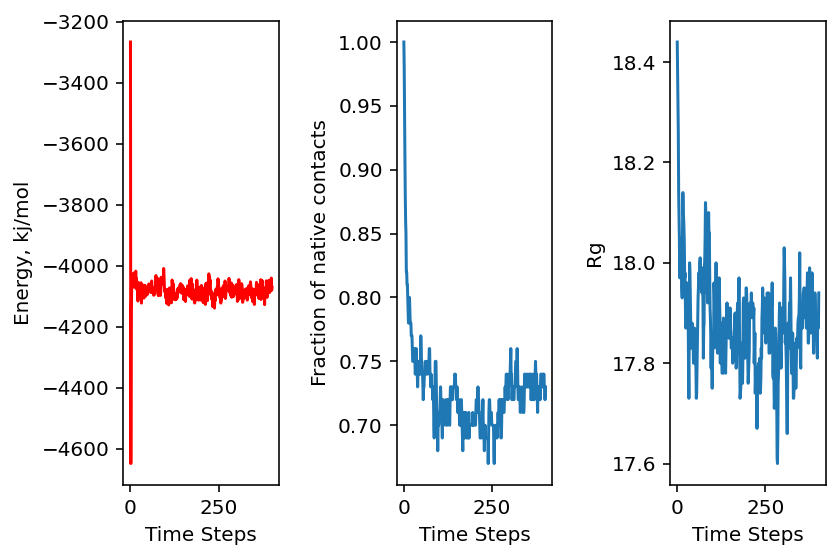

In [ ]:
#@markdown Plot timeseries of observables of interest.
%config InlineBackend.figure_format = 'retina'
viz_q_e()

In [5]:
#@markdown ## Install analysis tools
%%capture
!pip install MDAnalysis
!git clone https://github.com/Dan-Burns/molecular_dynamics_analysis_tools.git
from molecular_dynamics_analysis_tools.useful_functions import identical_subunits
import numpy as np

In [6]:
### TODO ####
## Silence errors




#@markdown ## Perform RMSD clustering
from Bio.PDB import PDBParser
import MDAnalysis.analysis.encore as encore
import MDAnalysis as mda

#@markdown Set maximum number of clusters to generate.
#@markdown Trajectory will be clustered seperately into n=1 to n clusters.
#@markdown Subsequent RDC fitting will reveal the optimal ensemble size.
n_clusters = 5 #@param {type:"number"}

pdb   = 'template.pdb'
model = PDBParser().get_structure('structure',pdb)

# hold chain IDs and residue object lists
# use to compare the subunits and figure out if they're identical or not
chains = {chain.id: chain.get_unpacked_list() for chain in model.get_chains()}
########################## Test Zone 1 ########################
'''
def identical_subunits(chains):
 
  take dictionary of biopython unpacked chain lists and see if they're
  composed of an identical number of identical residues
  
  # Get just the resnames (not the whole biopython res object)
  res_dict = {chain: [res.resname for res in chains[chain]] 
                      for chain in chains.keys()}
  # index the chain ids (can't index dictionary keys directly)
  chain_ids = list(chains.keys())
  # if it's only one chain, we're not going to break the trajectory up
  if len(chain_ids) == 1:
    return(False)
  # if it's multiple chains, check if they are all identical
  else:
    test = [res_dict[chain_ids[i]] == res_dict[chain_ids[i+1]]
            for i in range(len(chain_ids)-1)]
  # will have one boolean if everything is True or anything is False
  return test[0]
'''
######################## End Test Zone 1 ######################

trajectory = 'movie.dcd'
structure = 'template.pdb'
u = mda.Universe(structure, trajectory)

#############################
# if it's a homo-multimer, separate the subunits and concatenate into
# a long single-subunit trajectory for clustering
# Otherwise deal with the trajectory and one or more subunits in its original form
if identical_subunits(chains) == True: ### NEW 1 of 2
  # make a dictionary of chain/subunit keys with atom selection values
  selections = {}
  for chain in chains.keys():
    selections[chain] = u.select_atoms('segid '+chain)

  # make a directory to hold the seperated subunits
  out_dir = 'seperated_trajectories/'
  if not os.path.exists(out_dir):
      os.makedirs(out_dir)
  # clean the directory if it already exists
  for f in os.listdir(out_dir):
      os.remove(out_dir+f)

  # Instead of writing the seperated trajectories to files, 
  # can probably use u.merge() - but people might want to download trajectories...
  # Add a check for identical subunits, if True continue like this,
  # if False, continue with unseperated trajectories
  for chain, selection in selections.items():
      with mda.Writer(f'{out_dir}chain_{chain}.dcd', selection.n_atoms) as W:
          for ts in u.trajectory:
              W.write(selection)
  # write one subunit to a pdb
  # can probably just use the selection instead of a saved pdb
  # assuming we're just working with EI dimer for this
  selections[list(selections.keys())[0]].write('one_subunit.pdb')
 
  # align the seperated subunit trajectory
  from MDAnalysis.analysis import align
  # conatenate
  seperated_trajs = [out_dir+traj for traj in os.listdir(out_dir) if traj.endswith('dcd')]
  pdb = 'one_subunit.pdb'
  ref = mda.Universe(pdb)
  sep_u = mda.Universe(pdb, seperated_trajs)
  aligned_traj_name = 'aligned_seperated_subunits.dcd'
  align.AlignTraj(sep_u, ref,select='name CA',filename=aligned_traj_name).run()


else: ## just align the original trajectory for clustering New 2 of 2
  from MDAnalysis.analysis import align
  aligned_traj_name = 'aligned_traj.dcd'
  align.AlignTraj(u, pdb, select='name CA',filename=aligned_traj_name).run()

for cluster_iteration in range(n_clusters):
    structure = pdb
    trajectory = aligned_traj_name
    u = mda.Universe(structure, trajectory)
    # add n_jobs argument so that all n_init are run in parallel (default is 10)
    ensemble = encore.cluster(u, method=encore.clustering.ClusteringMethod.KMeans(n_clusters=cluster_iteration+1))
    #####################################
    # change this selection from 'name CA' to 'protein' when using structure file with 
    # correct residue names
    #####################################
    selection = u.select_atoms('protein')
    ######################################
    clusters = []
    for i, cluster in enumerate(ensemble.clusters):
        u.trajectory[cluster.centroid]
        if not os.path.exists(f'cluster_{cluster_iteration+1}/'):
          os.makedirs(f'cluster_{cluster_iteration+1}/')
        selection.write(f'cluster_{cluster_iteration+1}/centroid_{i+1}.pdb')
        clusters.append(int(cluster.centroid))


/usr/local/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/usr/local/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:448: UserWarning: No dimensions set for current frame, zeroed unitcell will be written
  warnings.warn(wmsg)
/usr/local/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:753: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/usr/local/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value

# Upload RDC Data

In [7]:
from google.colab import files
uploaded_rdcs = files.upload()

for fn in uploaded_rdcs.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded_rdcs[fn])))
  os.rename(fn, 'rdcs.dat')

Saving RDC_obs to RDC_obs
User uploaded file "RDC_obs" with length 1277 bytes


In [8]:
!pip install paramagpy
from molecular_dynamics_analysis_tools.rdcs import *
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 2.5 MB/s eta 0:00:00


/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3388
  warnings.warn(
/usr/local/lib/python3.9/site-packages/paramagpy/fit.py:90: UserWarning: 0.0 value uncertainty. All values weighted evenly
  warnings.warn("0.0 value uncertainty. All values weighted evenly")
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3388
  warnings.warn(
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3388
  warnings.warn(
/usr/local/lib/python3.9/site-packages/paramagpy/fit.py:90: UserWarning: 0.0 value uncertainty. All values weighted evenly
  warnings.warn("0.0 value uncertainty. All values weighted evenly")
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3388
  warnings.warn(


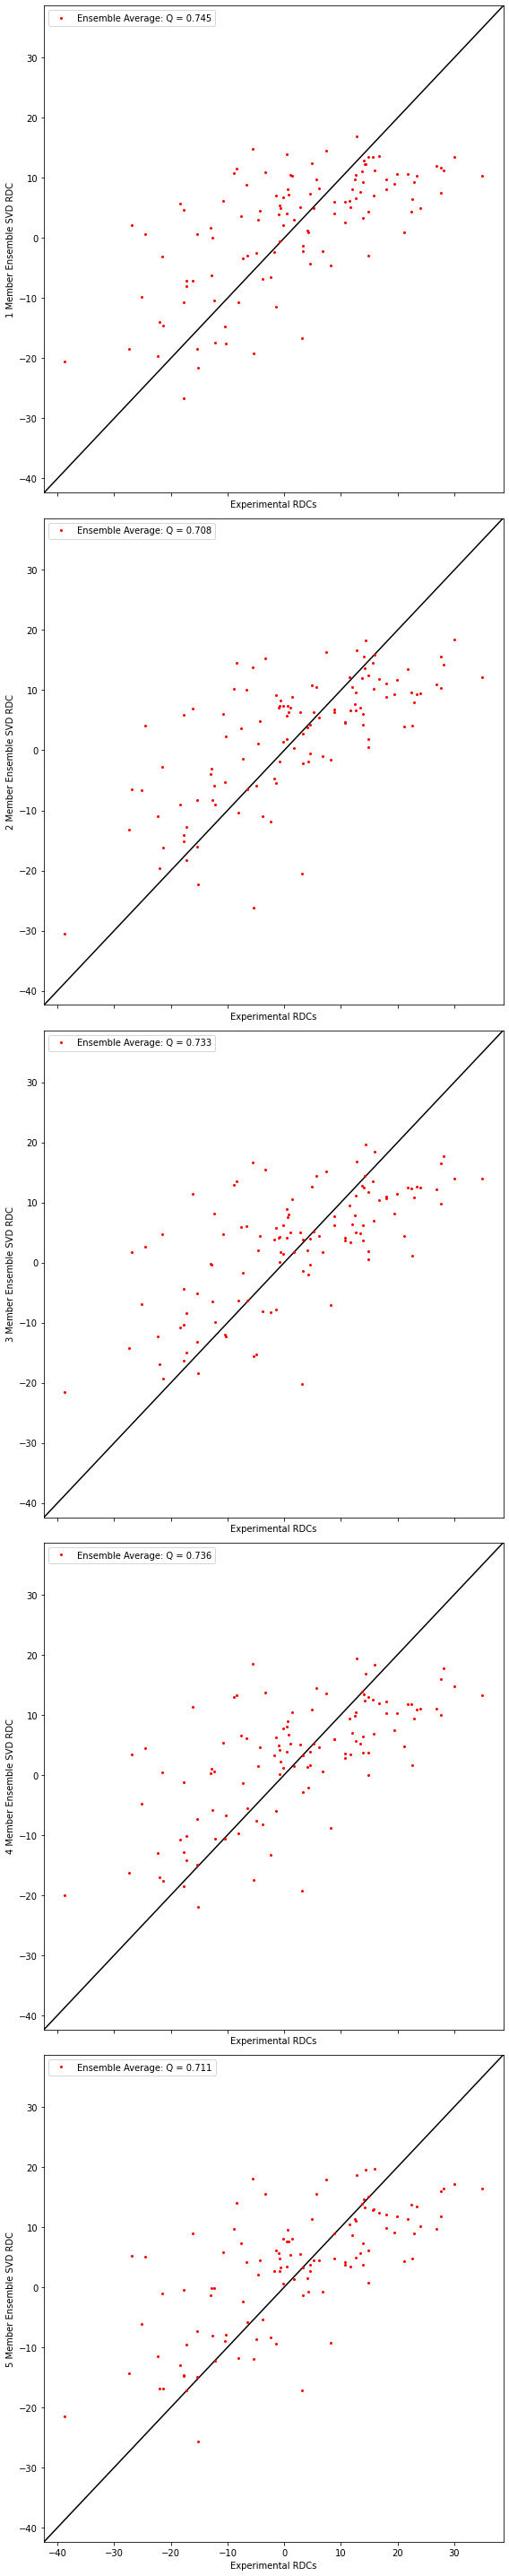

In [9]:
rdc_file = 'rdcs.dat'
# check the rdc file format
rdc_file_format = determine_rdc_file_format(rdc_file)
format_rdc_file(rdc_file, rdc_file_format, 'formatted_rdcs.dat')

# set up directories for saving the SVD fitting results
rdc_plots = 'svd_rdc_fitting_plots'
calculated_rdcs = 'svd_calculated_rdcs'
if os.path.exists(rdc_plots):
  pass
else:
  os.makedirs(rdc_plots)
if os.path.exists(calculated_rdcs):
  pass
else:
  os.makedirs(calculated_rdcs)
# store the multi-pdb files made from the different centroid sets in a seperate directory
if os.path.exists('cluster_ensemble_pdbs'):
  pass
else:
  os.makedirs('cluster_ensemble_pdbs')

# make a list of the folders that contain the cluster iteration centroids
# will have to change the list comprehension if we add option to do specific cluster iterations
cluster_folders = [f'cluster_{i+1}' for i in range(n_clusters)]
# specify magnet strength in T
#@markdown Specify magnetic field strength in T (default = 18.0).
magnetic_field = 18.0 #@param {type:"number"}
#@markdown Specify temperature of aligned sample in K 
# Can we get the variable from the simulation to populate the input here?
Temperature = 300.00 #@param (type:"number")


# set up subplots 
fig, axs = plt.subplots(n_clusters,1,
                        sharex=True,sharey=True,
                        figsize=(8,n_clusters*8))
# do all the fits and plots in a loop
for i in range(n_clusters):



  tensor = metal.Metal(B0=magnetic_field, temperature=Temperature)
  cluster_folder = cluster_folders[i]


  # make a multi-pdb file
  ensemble_pdb = f'cluster_ensemble_pdbs/{i+1}_centroids_ensemble.pdb'
  centroids = [f'{cluster_folder}/{pdb_file}' for pdb_file in os.listdir(cluster_folder)]
  make_multi_pdb_file(ensemble_pdb, centroids)

  # make paramagpy pdb/rdc object
  prot = protein.load_pdb(ensemble_pdb)
  rdc_prot = prot.parse(dataparse.read_rdc('formatted_rdcs.dat'))

  # SVD Fit
  [solution], [data] = fit.svd_fit_metal_from_rdc([tensor],
                                                  [rdc_prot],
                                                  ensembleAverage=True
                                                  )

  qfactor = fit.qfactor(data, ensembleAverage=True)

  # ensemble average RDC
  EA = fit.ensemble_average(data)
  # convert to dataframe to save CSV for download of residue numbers and calculated RDC
  df = pd.DataFrame({'resids':[atom.full_id[3][1] for atom in EA['atm']], 'RDCs':EA['cal']})
  df.to_csv(f'{calculated_rdcs}/{i+1}_member_ensemble_rdcs.csv')
  # save qfactor to text file
  with open(f"{calculated_rdcs}/{i+1}_member_ensemble_q_factor.txt",'w') as f:
    f.write(str(qfactor))


  # plot
  axs.flat[i].plot(EA['exp'], EA['cal'], marker='o', lw=0, ms=2, c='r',
          label=f'Ensemble Average: Q = {round(qfactor,3)}')

  # plot the diagonal
  l, h = axs.flat[i].get_xlim()
  axs.flat[i].plot([l,h],[l,h],'-k', zorder=0, ms=2)
  axs.flat[i].set_xlim(l,h)
  axs.flat[i].set_ylim(l,h)

  # labels
  axs.flat[i].set_xlabel("Experimental RDCs")
  axs.flat[i].set_ylabel(f"{i+1} Member Ensemble SVD RDC")
  axs.flat[i].legend()
fig.tight_layout()
fig.savefig(f'{rdc_plots}/ensemble_rdc_fits.pdf')


In [ ]:
#@title Package and download clustering results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `Clustering_output.zip`, right-click and select \"Download\".

%%capture
!zip -FSr "Clustering_output.zip" cluster_*
files.download("Clustering_output.zip")

  adding: cluster_1/ (stored 0%)
  adding: cluster_1/centroid_1.pdb (deflated 77%)
  adding: cluster_10/ (stored 0%)
  adding: cluster_10/centroid_3.pdb (deflated 77%)
  adding: cluster_10/centroid_5.pdb (deflated 77%)
  adding: cluster_10/centroid_8.pdb (deflated 77%)
  adding: cluster_10/centroid_9.pdb (deflated 77%)
  adding: cluster_10/centroid_1.pdb (deflated 77%)
  adding: cluster_10/centroid_10.pdb (deflated 77%)
  adding: cluster_10/centroid_6.pdb (deflated 77%)
  adding: cluster_10/centroid_2.pdb (deflated 77%)
  adding: cluster_10/centroid_4.pdb (deflated 77%)
  adding: cluster_10/centroid_7.pdb (deflated 77%)
  adding: cluster_2/ (stored 0%)
  adding: cluster_2/centroid_1.pdb (deflated 77%)
  adding: cluster_2/centroid_2.pdb (deflated 77%)
  adding: cluster_3/ (stored 0%)
  adding: cluster_3/centroid_3.pdb (deflated 77%)
  adding: cluster_3/centroid_1.pdb (deflated 77%)
  adding: cluster_3/centroid_2.pdb (deflated 77%)
  adding: cluster_4/ (stored 0%)
  adding: cluster_4/cen

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Perform PCA on cartesian positions of protein backbone

traj = md.load('movie.dcd', top='input-openmmawsem.pdb')

traju =  traj.superpose(reference=traj)

sel_ca   = traju.topology.select('name CA')

pos = traju.xyz[:, sel_ca, :] #time, atoms, 3
pos_data = pos.reshape(traju.n_frames, -1)

ll, V, proj = get_pca(pos_data)

#print('Origina data shape', 'Reduced data shape')
df = pd.DataFrame(proj, columns=[f'PC{i+1}' for i in range(10)])
df['Steps'] = df.index

fig = px.scatter_matrix(df,
        dimensions=["PC1", "PC2", "PC3"],
        color="Steps" 
        )
  
fig.update_traces(diagonal_visible=False)
fig.show()